In [1]:
1+1

2

### Description

March 27, 2025

I will use this notebook to make plots that will be used for making my request to access the near sideband.

Plan:

With MC, apply all cuts EXCEPT cuts I flip for s.b. and track length cut. Show that with this choice of near s.b., signal in sideband is small, even when scaled to best model benchmark. Include the CV weights and the uncertainties on signal and background MC.


Need: 

CV weights and uncertainties on both signal and bg MC. I have so many samples now, so for this exercise I should strategically choose a subset of the samples to do the study on (less processing time to get full uncertainties).

Note: I have already processed these for the nu background, and they are stored at /exp/icarus/data/users/jdyer/muon_datamc/samples_240909/allMC_ie_no_restriction_to_sideband_wConcreteFix_240909/

- the mc_coh file was made from just one of the cohlike samples (cohlike_nu_file = gray_df_dir + "F-CohLike_nom_evt.df").
- the mc_incoh never explicitly had the cohlike events masked out of it by me. But that was taken care of within the make_dataset() function. 

Here, I need to also process the CV weights and uncertainties for some signal benchmarks.



In [2]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import pickle
import h5py
import math

from util import *
import var
import cut
import data
import hist

import importlib

import pid
from pyanalib import panda_helpers
import os
import multiprocessing

from unc_funcs import *
from unc_samples import *
#from unc_MCdata_overhead import *
from unc_cuts import *

#import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#import subprocess

## Samples I'll use here (subset of all the samples)
(This content would normally be in unc_MCdata_overhead.py, but since I'm doing just a subset of the samples for this exercise, I'm going to contain it to this notebook.)

- Nominal nu sample: nu_file
- Cohlike nus: cohlike_nu_file
- Cohlike detector variations: cohlike_nu_detVar_files

In [3]:
onbeamR1_pot = 4.651603646822754e+19
print('onbeamR1_pot: ', onbeamR1_pot)
onbeamR1_livetime = 9712335.74

onbeamR2_pot = 1.9447555727369336e+20
print('onbeamR2_pot: ', onbeamR2_pot)
onbeamR2_livetime = 40955958.70833331

onbeam_pot = onbeamR1_pot + onbeamR2_pot
print('Combined onbeam POT: ', onbeam_pot)
GOAL_POT = onbeam_pot

print(GOAL_POT)

onbeamR1_pot:  4.651603646822754e+19
onbeamR2_pot:  1.9447555727369336e+20
Combined onbeam POT:  2.409915937419209e+20
2.409915937419209e+20


In [4]:
savedir = '/exp/icarus/data/users/jdyer/muon_CVwgts_y_systs_2503/'
savedir = '/exp/icarus/data/users/jdyer/muon_CVwgts_y_systs_2506/' # These have correctyed CV weights.



### June 16, 2025

In [5]:
import uproot
def histdf(h):
    values = h.values()
    bins = h.axis().edges()
    idx = pd.IntervalIndex.from_breaks(bins)
    return pd.Series(values, idx, name=None)
           
def getallpdg_histdf(d, prefix, pdgs=None):
    if pdgs is None:
        pdgs = {
            "numu": 14,
            "numubar": -14,
            "nue": 12,
            "nuebar": -12 
        }

    hs = []
    for pdgname, pdgcode in pdgs.items():
        h = histdf(d[prefix + pdgname])
        h.index = pd.MultiIndex.from_product([[pdgcode], h.index], names=["pdg", "E"])
        hs.append(h)
    return pd.concat(hs)
FLUX_CORRECTION_FILE = "/pnfs/icarus/persistent/users/faabdalr/2025-04-08_out_450.37_7991.98_79512.66.root"
FLUX_CORRECTION_HIST_PREFIX = "g4numi_reweight_v02_-->v03_02.hnom_"
pdgs = {
    "numu_weights": 14,
    "numubar_weights": -14,
    "nue_weights": 12,
    "nuebar_weights": -12, 
    # or, use parent PDG to reweight:
    "numu_kpm_weights": 321, 
    "numubar_kpm_weights": -321, 
    "nue_k0l_weights": 130
    }


In [ ]:
fluxcorr = getallpdg_histdf(uproot.open(FLUX_CORRECTION_FILE), FLUX_CORRECTION_HIST_PREFIX, pdgs)



In [ ]:
fluxcorr



In [ ]:
print('Jamie')


## Stuff to Run Once:

In [ ]:
# Investigate: What happens with cosmics in the act of masking cohlike events out of the nominal neutrino sample?

nomnu_evt = data.mc_dataset(nu_file, "evt", mcnukey="mcnuwgt")#, mccut=mccut)

In [ ]:
# Q: How many slices classified as cosmic in the cohlike sample are considered cohlike by the "is_coh_like" function?


In [ ]:
cats = make_categories(nomnu_evt, detailed_nu='int_type')
for c in cats:
    print(c.name, nomnu_evt[c].shape, sep=': ')

In [ ]:
# Notes:
# - maybe pile up. Run the same check, but for events instead of slices.
# - something to fix: 
#     - remove EVENTS (not slices) that have any cohlike slice in them from nominal sample.
#.    - OR, only keep the cohlike neutrinos in the cohlike sample and keep my fix the same (ie remove cohlike neutrinos/slices forom nominal)
# 

In [ ]:
mccoh_evt = pd.read_hdf(filedir + "mc_coh", "evt")


In [ ]:
print(mccoh_evt.shape)
print(mccoh_evt[is_coh_like_JD(mccoh_evt)].shape)
# TAKEAWAY: not every reconstructed slice in the cohlike sample is considered cohlike by the cohlike-identifier function

In [ ]:
coh_cats = make_categories(mccoh_evt, detailed_nu='int_type')
for c in coh_cats:
    print(c.name)
    print('\t shape of this category: ', mccoh_evt[c].shape)
    print('\t shape of this category that is considered cohlike: ', mccoh_evt[c][is_coh_like_JD(mccoh_evt[c])].shape)
    print(' ')

In [ ]:
coh_cosmics = mccoh_evt[coh_cats[-1]]
print(coh_cosmsics.shape)

In [ ]:
evt_test1 = data.mc_dataset(cohlike_nu_file, "evt", mcnukey="mcnuwgt")
evt_test2 = data.mc_dataset(cohlike_nu_file, "evt", mcnukey="mcnuwgt", mccut=is_coh_like)
evt_test3 = data.mc_dataset(cohlike_nu_file, "evt", mcnukey="mcnuwgt", mccut=~is_coh_like)



In [ ]:
print('All cohlike: ', evt_test1.df.shape)
print('Cohlike from cohlike: ', evt_test2.df.shape)
print('Cohlike_JD from cohlike: ', evt_test1.df[is_coh_like_JD(evt_test1.df)].shape)
print('')
print('Not-cohlike from cohlike: ', evt_test3.df.shape)
print('Not-Cohlike_JD from cohlike: ', evt_test1.df[~is_coh_like_JD(evt_test1.df)].shape)
print('')

print(evt_test2.df.shape[0] + evt_test3.df.shape[0])
print('')
print(evt_test1.df[~is_coh_like_JD(evt_test1.df)].shape[0] + evt_test1.df[is_coh_like_JD(evt_test1.df)].shape[0])

In [ ]:
# Takeaway number 1: is_coh_like and ~is_coh_like are not orthogonal (which is effed.)
# Takeaway number 2: is_coh_like_JD and ~is_coh_like_JD ARE orthogonal (which is fair and just)
# Takeaway number 3: I should use is_coh_like_JD instead of is_coh_like when I make my dataframes.

In [12]:
filedir = savedir
mc_incoh_evt = pd.read_hdf(filedir + "mc_incoh", "evt")
mccoh_evt = pd.read_hdf(filedir + "mc_coh", "evt")


In [15]:
print('All cohlike: ', mccoh_evt.shape)
#print('Cohlike from cohlike: ', evt_test2.df.shape)
print('Cohlike_JD from cohlike: ', mccoh_evt[is_coh_like_JD(mccoh_evt)].shape)
print('Not-Cohlike_JD from Cohlike: ', mccoh_evt[~is_coh_like_JD(mccoh_evt)].shape)
print('')
print('All Not-cohlike: ', mc_incoh_evt.shape)
print('Cohlike from Not-cohlike: ', mc_incoh_evt[is_coh_like_JD(mc_incoh_evt)].shape)
print('Not-Cohlike_JD from All Not-cohlike: ', mc_incoh_evt[~is_coh_like_JD(mc_incoh_evt)].shape)
print('')

#print(evt_test2.df.shape[0] + evt_test3.df.shape[0])
#print('')
#print(evt_test1.df[~is_coh_like_JD(evt_test1.df)].shape[0] + evt_test1.df[is_coh_like_JD(evt_test1.df)].shape[0])

All cohlike:  (103855, 788)
Cohlike_JD from cohlike:  (103855, 788)
Not-Cohlike_JD from Cohlike:  (0, 788)

All Not-cohlike:  (220197, 788)
Cohlike from Not-cohlike:  (0, 788)
Not-Cohlike_JD from All Not-cohlike:  (220197, 788)



In [ ]:
# end of study.

In [5]:
nmu = var.DF.iscc & ((var.DF.pdg == 14) | (var.DF.pdg == -14))
npi = var.DF.npi
ns = var.DF.nsm + var.DF.nsp
is_coh_like = (nmu + npi + ns >= 2) & (var.DF.max_proton_ke < 0.05)

def resave_datasets(df_names, df_list, output):
    with pd.HDFStore(output) as hdf:
        for k,df in zip(df_names, df_list):
            try:
                hdf.put(key=k, value=df, format="fixed")
            except Exception as e:
                print("Table %s failed to save, skipping. Exception: %s" % (k, str(e)))

In [6]:
# 4/3/25: make a function to do this so I don't have to copy/paste this block for every sample.

def JD_make_cvDF_w_cvWgt_and_systs(file, label, savedir=savedir, mccut=None,
                                   mc=True, mc_incoh=False, mccoh=False,
                                   bsm=False, hps=False, alp=False,
                                   onbeam=False, offbeam=False, Run1=False, Run2=False,
                                  ):
    print('file: ', file)
    if mc:
        evt = data.mc_dataset(file, "evt", mcnukey="mcnuwgt")#, mccut=mccut)
        evt_df = evt.df
        if mccut is not None:
                print('recognized mccut')
                print('shape of evt_df before applying mccut: ', evt_df.shape)
                evt_df = evt_df[mccut(evt_df)]
                print('shape of evt_df after applying mccut: ', evt_df.shape)
        evt_df["mc"] = mc
        evt_df["mc_incoh"] = mc_incoh
        evt_df["mccoh"] = mccoh
        evt_df["bsm"] = bsm
        ## WIP (and may not follow through)
        #if hps=True:
        #    mchdf = pd.read_hdf(file, key="mch")
        #    evt_df["mass"] = int(round(mchdf.iloc[(0)].M*1000.))
        #    evt_df["theta"] = float(mchdf.iloc[(0)].C1)
        #    evt_df["sample"] = "$M_S$ = %a, $\\theta_S$ = %a" % (int(round(mchdf.iloc[(0)].M*1000.)), float(mchdf.iloc[(0)].C1))
        #else:
        #    evt_df["mass"] = -1
        #    evt_df["theta"] = -1
        #    evt_df["sample"] = 'na'
        evt_df["hps"] = hps
        evt_df["alp"] = alp
        evt_df["onbeam"] = evt_df["offbeam"] = evt_df["Run1"] = evt_df["Run2"] = False
    evt_df['livetime'] = evt.livetime
    evt_df['POT'] = evt.POT
    #print('livetime: ', evt.livetime)
    #print('POT: ', evt.POT)
    evt_df = evt_df[satisfies_new_FV(evt_df)] # Make sure FV definition is up to date (so that we don't accept any too-short non-fiducial events)
    when_uncontained = ~TrkInFV(evt_df.trunk.trk.end) | ~TrkInFV(evt_df.branch.trk.end) # Require exiting
    evt_df = evt_df[when_uncontained]
    evt_df = add_calculated_evtdf_cols(evt_df)#, newcol_name=None, newcol_val=None)
    # resave dataset with lightened evt dataframe:
    df_names = ['evt', 'hdr', 'mch', 'mcnu']
    resave_datasets(df_names, 
                    [evt_df,
                     pd.read_hdf(file, "hdr"),
                     pd.read_hdf(file, "mch"),
                     pd.read_hdf(file, "mcnu")
                    ], 
                    savedir+label
                   )
    del evt
    del evt_df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

In [5]:
print(savedir)

/exp/icarus/data/users/jdyer/muon_CVwgts_y_systs_2503/


In [31]:
# CV signal samples: (fast cell)

# Nus:
JD_make_cvDF_w_cvWgt_and_systs(nu_file, 'mc_incoh', mccut=is_NOT_coh_like_JD, mc_incoh=True)
JD_make_cvDF_w_cvWgt_and_systs(cohlike_nu_file, 'mc_coh', mccut=is_coh_like_JD, mccoh=True)

# HPS:
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M220_nom_evt.df", 'mS_220', bsm=True, hps=True)
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M260_nom_evt.df", 'mS_260', bsm=True, hps=True)
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M300_nom_evt.df", 'mS_300', bsm=True, hps=True)
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M340_nom_evt.df", 'mS_340', bsm=True, hps=True)

# ALPs:
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma300_faE6.df", 'ma_300', bsm=True, alp=True)
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma350_faE6.df", 'ma_350', bsm=True, alp=True)
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma400_faE6.df", 'ma_400', bsm=True, alp=True)
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma450_faE6.df", 'ma_450', bsm=True, alp=True)

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-MCNuPhase2_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Na

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Na

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M220_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M260_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M300_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance 

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M340_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma300_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma350_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma400_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma450_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance 

In [34]:
print(cohlike_nu_file)

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_nom_evt.df


In [16]:
# Signal Sample Detector Variations:

def JD_make_dvDF_w_cvWgt_and_systs(detVar_files, label, savedir=savedir, mccut=None,
                                   mc=True, mc_incoh=False, mccoh=False, 
                                   bsm=False, hps=False, alp=False,
                                   onbeam=False, offbeam=False, Run1=False, Run2=False,
                                  ):
    # Note: I shouldn't ever need mccut, since I don't consider detector variations for the incoh sample.
    for i, file in enumerate(detVar_files):
        print(file, detVar_labels[i], sep=' ')
        if mc:
            evt = data.mc_dataset(file, "evt", mcnukey="mcnuwgt")#, mccut=mccut)
            evt_df = evt.df
            if mccut is not None:
                print('recognized mccut')
                print('shape of evt_df before applying mccut: ', evt_df.shape)
                evt_df = evt_df[mccut(evt_df)]
                print('shape of evt_df after applying mccut: ', evt_df.shape)
            evt_df["mc"] = mc
            evt_df["mc_incoh"] = mc_incoh
            evt_df["mccoh"] = mccoh
            evt_df["bsm"] = bsm
            evt_df["hps"] = hps
            evt_df["alp"] = alp
            evt_df["onbeam"] = evt_df["offbeam"] = evt_df["Run1"] = evt_df["Run2"] = False
        evt_df['livetime'] = evt.livetime
        evt_df['POT'] = evt.POT#print('\n')
        #print('systFile: ', file)
        #print('livetime: ', evt.livetime)
        #print('POT: ', evt.POT)
        evt_df = evt_df[satisfies_new_FV(evt_df)] # Make sure FV definition is up to date (so that we don't accept any too-short non-fiducial events):
        when_uncontained = ~TrkInFV(evt_df.trunk.trk.end) | ~TrkInFV(evt_df.branch.trk.end)
        evt_df = evt_df[when_uncontained] # Require exiting
        evt_df = add_calculated_evtdf_cols(evt_df)
    
        # resave:
        output = savedir + label + '_' + detVar_labels[i].replace(' ', '_')
        try: 
            subprocess.run(['rm', output])
        except:
            print("Did not delete a pre-existing file.")
        with pd.HDFStore(output) as hdf:
            # save the evt key to the dataset:
            try:
                hdf.put(key='evt', value=evt_df, format="fixed")
            except Exception as e:
                print("Table %s failed to save, skipping. Exception: %s" % ('evt', str(e)))
            # save the hdr key to the dataset:    
            try:
                hdf.put(key='hdr', value=pd.read_hdf(file, "hdr"), format="fixed")
                hdf.put(key='mch', value=pd.read_hdf(file, "mch"), format="fixed")
                hdf.put(key='mcnu', value=pd.read_hdf(file, "mcnu"), format="fixed")
            except Exception as e:
                print("Table %s failed to save, skipping. Exception: %s" % ('hdr', str(e)))
            
        del evt
        del evt_df


In [17]:
# Nus:
JD_make_dvDF_w_cvWgt_and_systs(cohlike_nu_detVar_files, 'mc_coh', mccut=is_coh_like_JD, mccoh=True)


/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin0_evt.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (233595, 760)
shape of evt_df after applying mccut:  (172658, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin14_evt.df Middle Ind. Transparent


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (272208, 760)
shape of evt_df after applying mccut:  (206914, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0glo_evt.df Front Ind. Gain Low


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (201830, 760)
shape of evt_df after applying mccut:  (149572, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0ghi_evt.df Front Ind. Gain High


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (170350, 760)
shape of evt_df after applying mccut:  (129260, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_noiselhi_evt.df Noise 1.2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (247418, 760)
shape of evt_df after applying mccut:  (185533, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_sce2x_evt.df Space Charge 2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (251887, 760)
shape of evt_df after applying mccut:  (190269, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0nom_evt.df Ind0 Nom


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

recognized mccut
shape of evt_df before applying mccut:  (253317, 760)
shape of evt_df after applying mccut:  (191484, 760)


/tmp/ipykernel_3793047/2262295460.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc"] = mc
/tmp/ipykernel_3793047/2262295460.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evt_df["mc_incoh"] = mc_incoh
/tmp/ipykernel_3793047/2262295460.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_3793047/2262295460.py:45: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:45

In [19]:
# check: (delete cell after checking) ## Result: all good!

def extract_detVar_dfs(sample):
    syst_evtdfs = []
    syst_hdrs = []
    for syst in detVar_labels:
        syst = syst.replace(' ', '_')
        evtdf = pd.read_hdf(filedir + sample + '_' + syst, "evt")
        evtdf['scale']=GOAL_POT/evtdf.POT
        syst_evtdfs.append(evtdf)
        syst_hdrs.append(pd.read_hdf(filedir + sample + '_' + syst, "hdr"))
    return syst_evtdfs, syst_hdrs
mccoh_syst_evtdfs, mccoh_syst_hdrs = extract_detVar_dfs("mc_coh")


for df in mccoh_syst_evtdfs:
    print('All cohlike: ', df.shape)
    print('Cohlike_JD from cohlike: ', df[is_coh_like_JD(df)].shape)
    print('Not-Cohlike_JD from Cohlike: ', df[~is_coh_like_JD(df)].shape)
    print('')

All cohlike:  (88461, 789)
Cohlike_JD from cohlike:  (88461, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)

All cohlike:  (107035, 789)
Cohlike_JD from cohlike:  (107035, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)

All cohlike:  (76930, 789)
Cohlike_JD from cohlike:  (76930, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)

All cohlike:  (66868, 789)
Cohlike_JD from cohlike:  (66868, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)

All cohlike:  (95551, 789)
Cohlike_JD from cohlike:  (95551, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)

All cohlike:  (98147, 789)
Cohlike_JD from cohlike:  (98147, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)

All cohlike:  (98434, 789)
Cohlike_JD from cohlike:  (98434, 789)
Not-Cohlike_JD from Cohlike:  (0, 789)



In [ ]:
# Signal Detector Variations:

# Nus:
JD_make_dvDF_w_cvWgt_and_systs(cohlike_nu_detVar_files, 'mc_coh', mccut=is_coh_like_JD, mccoh=True)

# HPS
JD_make_dvDF_w_cvWgt_and_systs(higgs_220_detVar_files, 'mS_220', bsm=True, hps=True)
JD_make_dvDF_w_cvWgt_and_systs(higgs_260_detVar_files, 'mS_260', bsm=True, hps=True)
JD_make_dvDF_w_cvWgt_and_systs(higgs_300_detVar_files, 'mS_300', bsm=True, hps=True)
JD_make_dvDF_w_cvWgt_and_systs(higgs_340_detVar_files, 'mS_340', bsm=True, hps=True)

# ALPs



/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin0_evt.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin14_evt.df Middle Ind. Transparent


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0glo_evt.df Front Ind. Gain Low


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0ghi_evt.df Front Ind. Gain High


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_noiselhi_evt.df Noise 1.2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_sce2x_evt.df Space Charge 2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0nom_evt.df Ind0 Nom


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M220_ind1bin0_evt.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


In [10]:
JD_make_dvDF_w_cvWgt_and_systs(alp_300_detVar_files, 'ma_300', bsm=True, alp=True)


/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind1bin0.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind1bin14.df Middle Ind. Transparent


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind0glo.df Front Ind. Gain Low


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind0ghi.df Front Ind. Gain High


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_noiselhi.df Noise 1.2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_sce2x.df Space Charge 2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind0nom.df Ind0 Nom


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

## Every other time, start here


In [6]:

filedir = savedir



### Load CV dataframes: 

In [7]:
## mc_incoh
#print(h5py.File(filedir + "mc_incoh", 'r').keys())
mc_incoh_evt = pd.read_hdf(filedir + "mc_incoh", "evt")
mc_incoh_evt["scale"] = GOAL_POT/mc_incoh_evt.POT
mc_incoh_hdr = pd.read_hdf(filedir + "mc_incoh", "hdr")
#mc_incoh_evt = simpler_add_hdr_info(mc_incoh_evt, mc_incoh_hdr)

## mc_coh
mccoh_evt = pd.read_hdf(filedir + "mc_coh", "evt")
mccoh_evt["scale"] = GOAL_POT/mccoh_evt.POT
mccoh_hdr = pd.read_hdf(filedir + "mc_coh", "hdr")

## ms=220
mS_220_evt = pd.read_hdf(filedir + "mS_220", "evt")
mS_220_evt["scale"] = GOAL_POT/mS_220_evt.POT
mS_220_hdr = pd.read_hdf(filedir + "mS_220", "hdr")

## mS=260
mS_260_evt = pd.read_hdf(filedir + "mS_260", "evt")
mS_260_evt["scale"] = GOAL_POT/mS_260_evt.POT
mS_260_hdr = pd.read_hdf(filedir + "mS_260", "hdr")

## ms=300
mS_300_evt = pd.read_hdf(filedir + "mS_300", "evt")
mS_300_evt["scale"] = GOAL_POT/mS_300_evt.POT
mS_300_hdr = pd.read_hdf(filedir + "mS_300", "hdr")

## ms=340
mS_340_evt = pd.read_hdf(filedir + "mS_340", "evt")
mS_340_evt["scale"] = GOAL_POT/mS_340_evt.POT
mS_340_hdr = pd.read_hdf(filedir + "mS_340", "hdr")




In [8]:
higgs_params_list = []
higgs_files = [
    gray_df_dir + "F2-Higgs_M220_nom_evt.df",
    gray_df_dir + "F2-Higgs_M260_nom_evt.df",
    gray_df_dir + "F2-Higgs_M300_nom_evt.df",
    gray_df_dir + "F2-Higgs_M340_nom_evt.df"
]
higgs_labels = []
for f in higgs_files:
    mch_df = pd.read_hdf(f, key="mch")
    m = int(round(mch_df.iloc[(0)].M*1000.))
    th = float(mch_df.iloc[(0)].C1)
    label = "$M_S$ = %a, $\\theta_S$ = %a" % (m, th)
    higgs_labels.append(label)
    
for l in higgs_labels:
    print(l)
    

$M_S$ = 220, $\theta_S$ = 1e-05
$M_S$ = 260, $\theta_S$ = 1e-05
$M_S$ = 300, $\theta_S$ = 1e-05
$M_S$ = 340, $\theta_S$ = 1e-05


### Load detector variation dataframes

In [8]:
for i, j in enumerate(detVar_labels):
    print(cohlike_nu_detVar_files[i], detVar_labels[i], sep=': ')

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin0_evt.df: Middle Ind. Opaque
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin14_evt.df: Middle Ind. Transparent
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0glo_evt.df: Front Ind. Gain Low
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0ghi_evt.df: Front Ind. Gain High
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_noiselhi_evt.df: Noise 1.2x
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_sce2x_evt.df: Space Charge 2x
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0nom_evt.df: Ind0 Nom


In [9]:
def extract_detVar_dfs(sample):
    syst_evtdfs = []
    syst_hdrs = []
    for syst in detVar_labels:
        syst = syst.replace(' ', '_')
        evtdf = pd.read_hdf(filedir + sample + '_' + syst, "evt")
        evtdf['scale']=GOAL_POT/evtdf.POT
        syst_evtdfs.append(evtdf)
        syst_hdrs.append(pd.read_hdf(filedir + sample + '_' + syst, "hdr"))
    return syst_evtdfs, syst_hdrs


In [10]:
mccoh_syst_evtdfs, mccoh_syst_hdrs = extract_detVar_dfs("mc_coh")
mS_220_syst_evtdfs, mS_220_syst_hdrs = extract_detVar_dfs("mS_220")
mS_260_syst_evtdfs, mS_260_syst_hdrs = extract_detVar_dfs("mS_260")
mS_300_syst_evtdfs, mS_300_syst_hdrs = extract_detVar_dfs("mS_300")
mS_340_syst_evtdfs, mS_340_syst_hdrs = extract_detVar_dfs("mS_340")



In [11]:
ma_300_syst_evtdfs, ma_300_syst_hdrs = extract_detVar_dfs("ma_300")


In [ ]:
[print(l) for l in detVar_labels]

### Combine dataframes as needed

In [44]:
for c in mc_incoh_evt.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', '', '', '')
('slc', 'truth', 'parent_dc

In [13]:
cat_colors = soladero_lime
for df in evtdfs[:2]:
    cats = make_categories(df, detailed_nu='int_type')
    for c in cats:
        print(c.name, df[c].shape, sep=': ')
    print('Whole df shape: ', df.shape)
    print('Number of slices that are cohlike: ', df[is_coh_like_JD(df)].shape)
    print(' ')

NameError: name 'evtdfs' is not defined

In [12]:
evtdfs = [
    mc_incoh_evt,
    mccoh_evt, 
    mS_220_evt,
    mS_260_evt, 
    mS_300_evt, 
    mS_340_evt,
    #onbeam_hdr,
    #offbeam_hdr
]

new_evtdfs = []
for df in evtdfs:
    new_df = df[satisfies_new_FV(df)]
    new_evtdfs.append(add_calculated_evtdf_cols(new_df))
evtdfs = new_evtdfs

hdrs = [
    mc_incoh_hdr,
    mccoh_hdr, 
    mS_220_hdr,
    mS_260_hdr, 
    mS_300_hdr, 
    mS_340_hdr,
    #onbeam_hdr,
    #offbeam_hdr
]

evtdf = pd.concat(evtdfs, keys=np.arange(len(evtdfs)), names=['sample'])#, join='inner') 

# Detector variations (just for MC cohlike and bsm.)

bsm_detector_varis_dfs = [
    #mccoh_syst_evtdfs,
    mS_220_syst_evtdfs,
    mS_260_syst_evtdfs,
    mS_300_syst_evtdfs,
    mS_340_syst_evtdfs
]
bsm_detector_varis_hdrs = [
    #mccoh_syst_hdrs,
    mS_220_syst_hdrs,
    mS_260_syst_hdrs,
    mS_300_syst_hdrs,
    mS_340_syst_hdrs
]



/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:619: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Define plotting function 

In [13]:
cat_colors = soladero_lime


In [13]:
#print(evtdf["sample"].unique())
evtdf.loc[0,:,:,:]
evtdf.index.get_level_values('sample') == 0
print(evtdf.index.get_level_values('sample'))
[print(l) for l in higgs_labels]

df = evtdf
is_higgs = ( (df.slc.tmatch.idx >= 0) & (df.hps) & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0) )# Only consider muon channel, exclude any Higgs that decayed to pions.
print(df[is_higgs].index.get_level_values('sample').unique())

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
           dtype='int64', name='sample', length=384674)
$M_S$ = 220, $\theta_S$ = 1e-05
$M_S$ = 260, $\theta_S$ = 1e-05
$M_S$ = 300, $\theta_S$ = 1e-05
$M_S$ = 340, $\theta_S$ = 1e-05
Int64Index([2, 3, 4, 5], dtype='int64', name='sample')


In [14]:
# I need my own version of the "make categories" function, but for the different samples here.
    
# detailed_nu option will further classify the MC samples by types of neutrino interactions.

def make_categories(df, detailed_bsm = False, detailed_nu = 'int_type'):
# Use this function to categorize the MC samples (signal and bg) that are used in designing the event selection.
# options for 'detailed_nu' are: 'int_type', 'final_state', 'none'. Use 'int_type!' On 4/8/25, I verfied that int_type categories are same as what's used unc_funcs (make_categories func for MC studies)
    
    # DATA
    
    #onbeam = (df.loc[[2]])
    onbeam = (df.onbeam == True)
    onbeam.name = 'Onbeam Data'
    onbeam.color = 'black' #"#E6378F"
    
    #offbeam = (df.loc[[3]])
    offbeam = (df.offbeam == True)
    offbeam.name = 'Offbeam Data'
    offbeam.color = "#EC1C0E"

    
    # COSMICS
    #is_cosmic = (df.slc.tmatch.idx < 0)
    is_cosmic = ((df.slc.tmatch.idx < 0) & (df.bsm==False) ) # Note 5/2/25: this is different from other instances of make_categories function I have, and it's because since I am POT-normalizing to get background estimates, I shouldn't include model-dependent cosmics. (They are very few anyways.) 
    is_cosmic.name = "Cosmic"
    is_cosmic.color = soladero_lime[6] #"C3"
    
    # SIGNAL
    
    if detailed_bsm:
        
        is_higgs = ( (df.slc.tmatch.idx >= 0) & (df.hps) & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0) )# Only consider muon channel, exclude any Higgs that decayed to pions.
        higgs_benchmarks = []
        cat_hdrs = []
        for s, sample in enumerate(df[is_higgs].index.get_level_values('sample').unique()):
            bm = (is_higgs) & (df.index.get_level_values('sample') == sample)
            bm.name = higgs_labels[s]
            bm.color = blues[s]
            higgs_benchmarks.append(bm)
        #higgs_benchmark_names = df[is_higgs]["sample"].unique() # Made this change June 3 to avoid bug when applying cuts, where you eliminate all of one category so your results dataframe shape gets messed up. Hopefully this doesn't cause other problems.
        #print(higgs_benchmark_names)
        #for l in range(len(higgs_benchmark_names)):
        #    bm = is_higgs & (df["sample"] == higgs_benchmark_names[l])
        #    bm.name = higgs_benchmark_names[l]
        #    bm.color = blues[l]
        #    higgs_benchmarks.append( bm )    
        
        #is_alp = (df.slc.tmatch.idx >= 0) & df.alp & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0)
        ##is_alp.name = "ALP"
        #alp_benchmarks = []
        #alp_benchmark_names = df[is_alp]["sample"].unique()
        #for l in range(len(alp_benchmark_names)):
        #    bm = is_alp & (df["sample"] == alp_benchmark_names[l])
        #    bm.name = alp_benchmark_names[l]# + " (no sup.)"
        #    bm.color = greens[l]
        #    alp_benchmarks.append( bm )
        
        bsm_cats = higgs_benchmarks #+ alp_benchmarks
            
    else:
        is_bsm = (df.slc.tmatch.idx >= 0) & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0) & (df.hps | df.alp ) # ( df.higgs | df.hps | df.alp_withsup | df.alp_nosup )
        is_bsm.name = "BSM"
        is_bsm.color = "#191970" #, "#00FF7F" #"#000000"
        bsm_cats = [is_bsm]
    
    # NEUTRINOS
    
    is_nu = (df.slc.tmatch.idx >= 0) & ( df.mc_incoh | df.mccoh )
    
    if detailed_nu == 'int_type':
        
        nu_NC = (is_nu & df.mc & (df.slc.truth.iscc == 0))
        nu_NC.name = "$\\nu$ NC"
        nu_NC.color = cat_colors[0] #"#caa834" #"#EAC387"
        
        numu_CC_QE_MEC = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & ((df.slc.truth.genie_mode == 0) | (df.slc.truth.genie_mode == 10)) # CC QE+MEC
        numu_CC_QE_MEC.name = "$\\nu_\\mu$ CC QE+MEC"
        numu_CC_QE_MEC.color = cat_colors[1] 
        
        numu_CC_RES = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 1) # CC RES
        numu_CC_RES.name = "$\\nu_\\mu$ CC RES"
        numu_CC_RES.color = cat_colors[2]
        
        numu_CC_DIS = is_nu & df. mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 2) # CC DIS
        numu_CC_DIS.name = "$\\nu_\\mu$ CC DIS"
        numu_CC_DIS.color = cat_colors[3] 
        
        numu_CC_COH = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 3) # CC COH
        numu_CC_COH.name = "$\\nu_\\mu$ CC COH"
        numu_CC_COH.color = cat_colors[4]
        
        #
        nu_other = is_nu & df.mc & ~nu_NC & ~numu_CC_QE_MEC & ~numu_CC_RES & ~numu_CC_DIS & ~numu_CC_COH
        nu_other.name = "$\\nu$ Other"
        nu_other.color = cat_colors[5]  
        
        nu_cats = [nu_NC] + [numu_CC_QE_MEC] + [numu_CC_RES] + [numu_CC_DIS] + [numu_CC_COH] + [nu_other]
    
    if detailed_nu == 'final_state':
        numu_cc_coh = df.mc & (df.slc.truth.genie_mode == 3) & (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool'))
        numu_cc_coh.name = '$\\nu_\\mu$ CC COH'
        numu_cc_coh.color = '#FADD28' #oranges[0]
        
        numu_cc_npizp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) &
                         (df.slc.truth.max_proton_ke < 0.02) )
        numu_cc_npizp.name = "$\\nu_\\mu$ CC n$\\pi$0p"
        numu_cc_npizp.color = oranges[1]
        
        numu_cc_npinp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) & 
                         (df.slc.truth.max_proton_ke >= 0.02))
        numu_cc_npinp.name = '$\\nu_\\mu$ CC n$\\pi$np'
        numu_cc_npinp.color = oranges[2]
        
        numu_cc_other = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & 
                         (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool')) & 
                         ( (df.slc.truth.npi<1) | (df.slc.truth.npi0!=0) )
                        )
        numu_cc_other.name = '$\\nu_\\mu$ CC Other'
        numu_cc_other.color = oranges[3]
        
        not_numu_cc = (df.mc & ( (np.abs(df.slc.truth.pdg) != 14) | ~df.slc.truth.iscc.astype('bool') ))
        not_numu_cc.name = 'not $\\nu_\\mu$ CC'
        not_numu_cc.color = oranges[4]
        
        nu_cats = [numu_cc_coh] + [numu_cc_npizp] + [numu_cc_npinp] + [numu_cc_other] + [not_numu_cc]
    
    elif detailed_nu == 'none':
        
        nu_all = is_nu
        nu_all.name = 'MC $\nu$'
        nu_all.color = 'C2' 
        
        nu_cats = [nu_all] 
    
    # PUT THEM ALL TOGETHER
    
    for m in bsm_cats:
        m.mc_signal = True
        m.mc_bg = False
    for m in nu_cats:
        m.mc_signal = False
        m.mc_bg = True
    is_cosmic.mc_signal = False
    is_cosmic.mc_bg = True
    
    categories = bsm_cats + nu_cats + [is_cosmic]
    return categories

def filter_out_cosmics(df):
    is_cosmic = df.slc.tmatch.idx < 0
    return ~is_cosmic




In [15]:
categories = make_categories(evtdf, detailed_nu = 'int_type', detailed_bsm=True)
for c in categories:
    if c.mc_bg:
        print(c.name)
        #if '$\nu$' in c.name:
        if "Other" in c.name:
            print(c.name)
            
mc_bg_cats = [cat for cat in categories if cat.mc_bg]

print(len(categories))
print(len(mc_bg_cats))


NameError: name 'cat_colors' is not defined

In [20]:
print(mS_260_evt.shape)
test = filter_out_cosmics(mS_260_evt)
print(mS_260_evt[test].shape)

print(mS_220_evt.shape)
test = filter_out_cosmics(mS_220_evt)
print(mS_220_evt[test].shape)

print(np.sum(mS_220_evt[~test].scale))
for c in mS_220_evt.columns: print(c)

(15021, 789)
(7890, 789)
(9986, 789)
(2808, 789)
0.014250053
('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', '

In [28]:
for c in make_categories(evtdf, detailed_bsm=True):
    if c.mc_signal:
        print(c.name)
        #if '220' in c.name: print(c.name)
        
bsm_cats = [c for c in make_categories(evtdf, detailed_bsm=True) if c.mc_signal]


$M_S$ = 220, $\theta_S$ = 1e-05
$M_S$ = 260, $\theta_S$ = 1e-05
$M_S$ = 300, $\theta_S$ = 1e-05
$M_S$ = 340, $\theta_S$ = 1e-05


In [39]:
for df in mS_220_syst_evtdfs:
    print('total shape: ', df.shape)
    catss = make_categories(df)#, detailed_nu='none')
    for c in catss: print(c.name, ': ', df[c].shape)
    print('')

total shape:  (9939, 789)
BSM :  (2691, 789)
$\nu$ NC :  (0, 789)
$\nu_\mu$ CC QE+MEC :  (0, 789)
$\nu_\mu$ CC RES :  (0, 789)
$\nu_\mu$ CC DIS :  (0, 789)
$\nu_\mu$ CC COH :  (0, 789)
$\nu$ Other :  (0, 789)
Cosmic :  (0, 789)

total shape:  (10259, 789)
BSM :  (2898, 789)
$\nu$ NC :  (0, 789)
$\nu_\mu$ CC QE+MEC :  (0, 789)
$\nu_\mu$ CC RES :  (0, 789)
$\nu_\mu$ CC DIS :  (0, 789)
$\nu_\mu$ CC COH :  (0, 789)
$\nu$ Other :  (0, 789)
Cosmic :  (0, 789)

total shape:  (11001, 789)
BSM :  (2913, 789)
$\nu$ NC :  (0, 789)
$\nu_\mu$ CC QE+MEC :  (0, 789)
$\nu_\mu$ CC RES :  (0, 789)
$\nu_\mu$ CC DIS :  (0, 789)
$\nu_\mu$ CC COH :  (0, 789)
$\nu$ Other :  (0, 789)
Cosmic :  (0, 789)

total shape:  (10228, 789)
BSM :  (2890, 789)
$\nu$ NC :  (0, 789)
$\nu_\mu$ CC QE+MEC :  (0, 789)
$\nu_\mu$ CC RES :  (0, 789)
$\nu_\mu$ CC DIS :  (0, 789)
$\nu_\mu$ CC COH :  (0, 789)
$\nu$ Other :  (0, 789)
Cosmic :  (0, 789)

total shape:  (9945, 789)
BSM :  (2745, 789)
$\nu$ NC :  (0, 789)
$\nu_\mu$ CC QE

In [15]:
def apply_cuts(df, cuts, thresholds=None, detailed_bsm=False, detailed_nu='none', 
               flip_last_cut=False):
    
    #new_df = df.copy()
    categories = make_categories(df, detailed_bsm=detailed_bsm, detailed_nu=detailed_nu)
    
    # initialze data frames
    cut_results_df = pd.DataFrame(
        np.zeros((0,len(categories)), dtype=int), # start w/ zero rows (cuts), fill later
        columns = [c.name for c in categories]
    )
    cut_results_df_mc = cut_results_df.copy() #deep=True
    cut_results_df_pot = cut_results_df.copy() #deep=True
    cut_results_df_percent = cut_results_df.copy() #deep=True
    
    # fill in first row of data frame for "no cuts"
    row_mc = []
    row_pot = []
    for c in categories:
        #print(sum(df[c].scale))
        row_mc.append(df[c].shape[0])
        row_pot.append(round(100*sum(df[c].scale))/100.)
    cut_results_df_mc.loc["preselection"] = row_mc 
    first_row_mc = row_mc
    cut_results_df_pot.loc["preselection"] = row_pot
    cut_results_df_percent.loc["preselection"] = [1.] * len(row_pot)
    
    # Loop through cuts to make rows for data frame and to make master_mask
    master_mask = None
    for i in range(len(cuts)):
        if thresholds is None:
            func_output = cuts[i](*[df])
        else: 
            func_output = cuts[i](*[df], thresh=thresholds[i])
        if flip_last_cut: #overwrite with the flip
            if i == len(cuts)-1:
                func_output = cuts[i](*[df], flip=True)
        if i==0: 
            master_mask = func_output[0]
        else:
            master_mask = master_mask & func_output[0]
        new_df = df[master_mask]
        new_categories = make_categories(new_df, detailed_bsm=detailed_bsm, detailed_nu=detailed_nu)
        
        row_mc = []
        row_pot = []
        for c in new_categories:
            row_mc.append(new_df[c].shape[0])
            row_pot.append(round(100*sum(new_df[c].scale))/100.)
        cut_results_df_mc.loc[func_output[1]] = row_mc
        cut_results_df_pot.loc[func_output[1]] = row_pot
        cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
    
    return cut_results_df_mc, cut_results_df_pot, cut_results_df_percent, master_mask 


[1 1 1 1 1 1]
[3 3 3 3 3 3]


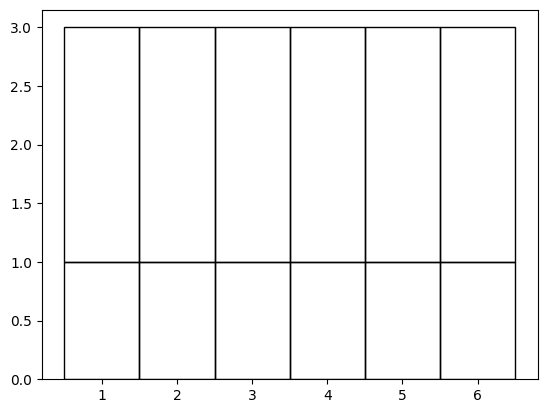

In [59]:
bin_centers = np.array([1,2,3,4,5,6])
unc_running_sum = np.array([0]*len(bin_centers))
mylist = [
    np.array([1]*len(bin_centers)),
    np.array([2]*len(bin_centers))
]
for l in mylist:
    plt.bar(bin_centers, l, 
            bottom = unc_running_sum,
            width=bin_centers[1]-bin_centers[0], 
            #label=uncertainties_labels[i], 
            fill=False, color=southwest[i])#, edgecolor=southwest[i])
    unc_running_sum = (l+unc_running_sum)
    print(unc_running_sum)
plt.show()

In [18]:
for c in evtdf.wgt.columns: #coh, #xsec, #flux, #g4
    print(c)

('cv', '', '', '', '')
('concrete', 'cv', '', '', '')
('coh', 'cv', '', '', '')
('coh', 'univ_0', '', '', '')
('coh', 'univ_1', '', '', '')
('coh', 'univ_2', '', '', '')
('coh', 'univ_3', '', '', '')
('coh', 'univ_4', '', '', '')
('coh', 'univ_5', '', '', '')
('coh', 'univ_6', '', '', '')
('coh', 'univ_7', '', '', '')
('coh', 'univ_8', '', '', '')
('coh', 'univ_9', '', '', '')
('coh', 'univ_10', '', '', '')
('coh', 'univ_11', '', '', '')
('coh', 'univ_12', '', '', '')
('coh', 'univ_13', '', '', '')
('coh', 'univ_14', '', '', '')
('coh', 'univ_15', '', '', '')
('coh', 'univ_16', '', '', '')
('coh', 'univ_17', '', '', '')
('coh', 'univ_18', '', '', '')
('coh', 'univ_19', '', '', '')
('coh', 'univ_20', '', '', '')
('coh', 'univ_21', '', '', '')
('coh', 'univ_22', '', '', '')
('coh', 'univ_23', '', '', '')
('coh', 'univ_24', '', '', '')
('coh', 'univ_25', '', '', '')
('coh', 'univ_26', '', '', '')
('coh', 'univ_27', '', '', '')
('coh', 'univ_28', '', '', '')
('coh', 'univ_29', '', '', '')


In [16]:
saveplots = False
plotdir = '/exp/icarus/data/users/jdyer/muon_datamc/plots/'
def makeplot(df, var, 
             syst_evtdfs, syst_vars, 
             myrange, xlabel = 'x axis', bins = 25, vline=None, detailed_nu='int_type', do_systs=True,
             POTSTR=POTSTR, title=None, ratio_bounds=None, plotname='noname', ylabel=None,
             textOnPlot = '', 
             bsm_index=None, bsm_detector_varis_vars=[], bsm_magnifier=1, 
             evtSel_key=None
            ): # , [-1,3]
    # options for 'detailed_mc' are: 'int_type', 'cd /exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-toolsfinal_state', 'none'
    # df: concatenation of mccoh, mcincoh, and bsm evt_dfs (data to come later)
    # var: corresponds to 'df' variable
    # syst_evtdfs: for the cohlike events and bsm
    # syst_vars: correspond to the 'syst_evtdfs'
    
    if bsm_index is not None:
        assert len(bsm_detector_varis_vars)>0, 'You need to provide the signal detector variation sample vars!'
        categories = make_categories(df, detailed_nu = detailed_nu, detailed_bsm=True)
        bsm_cats = [c for c in categories if c.mc_signal]
        bsm_cat = bsm_cats[bsm_index]
        bsm_df = df[bsm_cat]
        bsm_var = var[bsm_cat]
        bsm_syst_evtdfs = bsm_detector_varis_dfs[bsm_index]
        bsm_syst_vars = bsm_detector_varis_vars[bsm_index]
    
    # first apply event selection, if applicable:
    if evtSel_key is not None:
        cut_list = evtSel_dict[evtSel_key][0]
        thresholds = evtSel_dict[evtSel_key][1]
        
        # df, var:
        cut_results = apply_cuts(df, cut_list, thresholds=thresholds, detailed_nu='none')
        mask = cut_results[-1]
        df, var = df[mask], var[mask]

        # cohlike detector variations df, cohlike detector variations var
        new_syst_evtdfs, new_syst_vars = [], []
        for d, systdf in enumerate(syst_evtdfs):
            cut_results = apply_cuts(systdf, cut_list, thresholds=thresholds, detailed_nu='none')
            mask = cut_results[-1]
            new_syst_evtdfs.append(systdf[mask])
            new_syst_vars.append(syst_vars[d][mask])
        syst_evtdfs, syst_vars = new_syst_evtdfs, new_syst_vars
        
        # bsm detector variations df, bsm detector variations var
        if bsm_index is not None:
            cut_results = apply_cuts(bsm_df, cut_list, thresholds=thresholds, detailed_nu='none')
            mask = cut_results[-1]
            bsm_df = bsm_df[mask]
            bsm_var = bsm_var[mask]
        
            new_bsm_syst_evtdfs = []
            new_bsm_syst_vars = []
            for i, detector_variation in enumerate(bsm_syst_evtdfs):
                cut_results = apply_cuts(detector_variation, cut_list, thresholds=thresholds, detailed_nu='none')
                mask = cut_results[-1]
                new_bsm_syst_evtdfs.append(detector_variation[mask])
                new_bsm_syst_vars.append(bsm_syst_vars[i][mask])
            bsm_syst_evtdfs = new_bsm_syst_evtdfs 
            bsm_syst_vars = new_bsm_syst_vars
                
    fig, (p0, p1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3,1]}, sharex=True) #, figsize=(7, 6.4)
    fig.subplots_adjust(hspace=0.03)
    
    mydensity = False

    scale = df.scale.copy()
    #var[np.isnan(var) | (var < 0)] = -10
    var[np.isnan(var)] = -10
    
    if bsm_index is not None:
        categories = make_categories(df, detailed_nu = detailed_nu, detailed_bsm=True)
    else:
        categories = make_categories(df, detailed_nu = detailed_nu)  
    
    # DATA
    # (ignoring data for now.)
    
    # BG MC
    if detailed_nu == 'none': histtype_str = 'step'
    else: histtype_str = 'bar'
    _ = p0.hist([var[cat] for cat in categories if cat.mc_bg], #[:-2]], 
                weights = [df[cat].scale*df[cat].wgt.cv for cat in categories if cat.mc_bg], #[:-2]], 
                color=[cat.color for cat in categories if cat.mc_bg], #[:-2]],
                label=[cat.name for cat in categories if cat.mc_bg], #[:-2]],
                bins=bins, density=mydensity, histtype=histtype_str, stacked=True, range=myrange)
    returned_bins = _[1]
    bin_centers = 0.5*(returned_bins[1:] + returned_bins[:-1])
    try: mc = _[0][-1,:] # np.sum(np.array(_[0]), axis=0)
    except IndexError: mc = _[0]
    total_mc_bg_in_plot = np.sum(mc)
    mc_bin_nevents = []
    
    mc_evtdf = df[df.mc & ~df.bsm]
    mc_var = var[df.mc & ~df.bsm]
    unq = np.unique(np.array(mc_evtdf.scale))
    print('VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings): ', len(unq)) # for the cohlike and nominal samples (later there will be more cohlikes).
        
    # BG MC STATISTICAL
        
    for w in unq:
        temp = plt.hist(mc_var[mc_evtdf.scale == w], 
                        bins=bins, alpha=0, density=False, range=myrange)
        mc_bin_nevents.append(temp[0])
    mc_bin_nevents = np.array(mc_bin_nevents) 
    mc_stat_err = []
    for b in range(mc_bin_nevents.shape[1]):
        if len(unq) ==2.:
            mc_stat_err.append( np.sqrt( (unq[0]**2)*mc_bin_nevents[0,b] + (unq[1]**2)*mc_bin_nevents[1,b] ) )
        elif len(unq)==1:
            mc_stat_err.append( (unq[0])*np.sqrt(mc_bin_nevents[0,b]) )
        else: print('you need adjust the function now.')
    mc_stat_err = np.array(mc_stat_err)
    # Note: this is for the total number of mc_bg events in each bin - I don't have to worry about categories here, like distinction between cosmics and neutrinos.
    # Note: I include POT normalization (ie scale) in my stat err. (Is this correct?) YES! 
    #       I do NOT include a scaling due to wgt.cv in my stat err. (Is this correct?) NOPE. I NEED TO INCLUDE IT.
    ### I think I should do both or neither of these.
    ##
    # QUESTION TO REVISIT MAY 2025: INCLUDE POT NORMALIZATION IN STAT ERROR? INCLUDE CV WEIGHTS IN STAT ERR?
    #    I've handled the POT correctly here. I'm not doing anything with the cv weights, which I think is okay (enough).
        
    # BG MC SYSTEMATICS
    if do_systs:
        
        # UNIVERSE SYSTS - these include multi-sigma, multi-sim, and morph type systematic uncertainties.
        # JUNE 5, '25 TODO: "all" --> #coh, #xsec, #flux, #g4
        
        # ~~~~~~ SUM OVER UNIVERSES.
        
        # ~~ separate (#coh, #xsec, #flux, #g4)
        universe_contributions = ["coh", "xsec", "flux", "g4"]
        coh_weighted_hists = []
        xsec_weighted_hists = []
        flux_weighted_hists = []
        g4_weighted_hists = []
        universe_weighted_hists = [coh_weighted_hists, xsec_weighted_hists, flux_weighted_hists, g4_weighted_hists]
        universe_covs = []
        for uc, uni_cont in enumerate(universe_contributions):
            for col in mc_evtdf.wgt[uni_cont].columns:
                if not col[0].startswith("univ"): continue
                #hsyst_weights.append(histf(mc_evtdf.wgt["all"][col]))
                new_weighted_hist = plt.hist(
                    mc_var, 
                    weights = mc_evtdf.scale*mc_evtdf.wgt.cv*mc_evtdf.wgt[uni_cont][col],
                    bins=bins, alpha=0, density=mydensity, range=myrange
                )
                universe_weighted_hists[uc].append(new_weighted_hist[0])
            hcov = None
            # average over Universe (each Universe has a bunch of weights-based uncertainties in it)
            for i in range(len(universe_weighted_hists[uc])):
                thiscov = np.outer( mc - universe_weighted_hists[uc][i] , mc - universe_weighted_hists[uc][i] )
                if hcov is None:
                    hcov = thiscov
                else:
                    hcov += thiscov
            universe_covs.append(hcov/len(universe_weighted_hists[uc]))
        coh_cov = universe_covs[0]
        xsec_cov = universe_covs[1]
        flux_cov = universe_covs[2]
        g4_cov = universe_covs[3]
        
        # ~~ together ("all")
        
        #weighted_hists = []
        #for col in mc_evtdf.wgt["all"].columns:
        #    if not col[0].startswith("univ"): continue
        #    #hsyst_weights.append(histf(mc_evtdf.wgt["all"][col]))
        #    new_weighted_hist = plt.hist(
        #        mc_var, 
        #        weights = mc_evtdf.scale*mc_evtdf.wgt.cv*mc_evtdf.wgt["all"][col],
        #        bins=bins, alpha=0, density=mydensity, range=myrange
        #    )
        #    weighted_hists.append(new_weighted_hist[0])
        ## TODO: to get uncerts. from the simulation systematics, do similary to the detector variation ones, 
        ##      but use 'new_weighted_hist' as the plus/minus  from CV, 
        ##      BUT use contributions from xs, g4, and flux one at a time instead of the new_weighted_hist
        ##hsyst = SystSpectrum(hsyst_weights)
        
        #hcov = None
        ## average over Universe (each Universe has a bunch of weights-based uncertainties in it)
        #for i in range(len(weighted_hists)):
        #    thiscov = np.outer( mc - weighted_hists[i] , mc - weighted_hists[i] )
        #    if hcov is None:
        #        hcov = thiscov
        #    else:
        #        hcov += thiscov
        #Universe_cov = hcov / len(weighted_hists)
        
        ## ~~~~~~
                
        # BG MC DETECTOR SYSTEMATICS
        
        cohlike_hist = p0.hist(mc_var[is_coh_like_JD(mc_evtdf)], #df["mccoh"]==True],
                                weights = mc_evtdf[is_coh_like_JD(mc_evtdf)].scale * mc_evtdf[is_coh_like_JD(mc_evtdf)].wgt.cv, 
                                bins=bins, alpha=0, density=mydensity, range=myrange)

        #frac_cohlike = (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) / ( (mc_incoh_evt.shape[0]*GOAL_POT/mc_incoh_pot) +  (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) )
        frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)
        #print('frac_cohlike_bybin: ', frac_cohlike_bybin)
        
        detsyst_hists = []
        # TODO: double check that I am not incorrectly including cosmics from my detector variation samples.
        for s, mc_detsyst_var in enumerate(syst_vars):
            #mc_detsyst_var = sdf.Snumi_angle_mcs*180./math.pi # TODO: generalize this to any var.
            new_detsyst_hist = p0.hist(
                mc_detsyst_var, 
                weights = syst_evtdfs[s].scale*syst_evtdfs[s].wgt.cv,
                #weights = sdf.scale, 
                bins=bins, alpha=0, density=mydensity, range=myrange
            )
            detsyst_hists.append(new_detsyst_hist[0]/frac_cohlike_bybin)
                    
        # Middle Induction Transparency:
        middle_ind_cov = ( np.outer( mc - detsyst_hists[0] , mc - detsyst_hists[0] ) + np.outer( mc - detsyst_hists[1] , mc - detsyst_hists[1] ) )/2.        
        # Front Induction Gain:
        front_ind_gain_cov = ( np.outer( mc - detsyst_hists[2] , mc - detsyst_hists[2] ) + np.outer( mc - detsyst_hists[3] , mc - detsyst_hists[3] ) )/2.       
        # Noise High:
        noise_hi_cov = np.outer( mc - detsyst_hists[4] , mc - detsyst_hists[4] )        
        # Space Charge Effect x2:
        sce_cov = np.outer( mc - detsyst_hists[5] , mc - detsyst_hists[5] )        
        # Ind 0 Nom (?): # changing signal shapes on front induction to Wire Cell nominal. Our nominal (default) is garfield.
        # signal shape simulation is in wire cell (so is 2D convolution, but rn we do 1d deconv. which is not using Wire Cell.)
        ind0nom_cov = np.outer( mc - detsyst_hists[6] , mc - detsyst_hists[6] )
        detector = np.sqrt(np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
                           + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))

        
        #yerr_syst_total_combine_all_SimErrs = np.sqrt(np.diag(Universe_cov)+ 
        #                          np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
        #                          + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
        
        yerr_syst_total = np.sqrt(np.diag(coh_cov) + np.diag(xsec_cov) + np.diag(flux_cov) + np.diag(g4_cov) +
                                  np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
                                  + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
        #print('Combined result minus separate result: \n', yerr_syst_total_combine_all_SimErrs - yerr_syst_total)
        
        
    # BG TOTAL MC UNCERTAINTY
        
    if do_systs:
        mc_err = np.sqrt(mc_stat_err**2 + yerr_syst_total**2)
        mc_err_label = 'Stat. + Syst. Err.'
            
    else:
        mc_err = mc_stat_err
        mc_err_label = 'Stat. Err.'
    #print('mc_stat_err: ', mc_stat_err)
    #print('mc syst. err: ', yerr_syst_total)
    #print('mc_err: ', mc_err)
    total_mc_bg_err_in_plot = np.sqrt(np.sum((mc_err[np.isfinite(mc_err)])**2))
        
    #print('mc: ', mc)
    mc_minus_err = np.append((mc - mc_err), 0.)
    mc_minus_err[np.isnan(mc_minus_err)] = 0.
    mc_plus_err = np.append((mc + mc_err), 0.)
    mc_plus_err[np.isnan(mc_plus_err)] = 0.
    fill = p0.fill_between(returned_bins, mc_minus_err, mc_plus_err, step="post", hatch="//", label = mc_err_label, edgecolor="gray", facecolor="gray", alpha=0.4, linewidth=0) #label = 'MC Total Uncertainty', hatch="x", color="gray", alpha=0.5, 
    
    #print('MC EVENTS IN PLOT (w/ Normalization): ', np.sum(mc))
    #print('DATA/MC IN PLOT (w/ Normalization): ', np.sum(data)/np.sum(mc) )

    #print('bin boundaries:')
    #print(onbeam_data[1][:-1])
    ###
    
    ## SUB PLOT: NU UNCERTAINTIES BY BIN
    
    # QUESTION / TO DO: HAVE I BEEN SHOWING SOME DETECTOR VARIATION ERRORS INCORRECTLY?
    # pretty sure I am showing plus/minus whatever the np.diag(cov) gives 
    # is this wrong for the one-sided detector effects (ie noise hi, sceX2, and ind0nom)? Should those only have error in one direction?
    # Answer: No, I'm good! Look at where I'm averaging for individual detector variation effects.
    
    yerr_syst_total = np.sqrt(np.diag(coh_cov) + np.diag(xsec_cov) + np.diag(flux_cov) + np.diag(g4_cov) +
                                  np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
                                  + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
    
    uncertainties_sqrd_by_bin = [
        #np.diag(Universe_cov), # Universe systematics.
        np.diag(coh_cov), np.diag(xsec_cov), np.diag(flux_cov), np.diag(g4_cov),
        detector**2, # detector uncertainties combined 
        mc_stat_err**2 # statistical
    ]
    #uncertainties_labels = ["Universe systs"]+['detector']+['statistical']
    uncertainties_labels = universe_contributions+['detector']+['statistical'] # universe_contributions = ["coh", "xsec", "flux", "g4"]
    
    #uncertainties_sqrd_by_bin = [
    #    np.diag(Universe_cov), # Universe systematics.
    #    np.diag(middle_ind_cov), # middle induction transparency
    #    np.diag(front_ind_gain_cov), # front induction gain
    #    np.diag(noise_hi_cov), #noise hi
    #    np.diag(sce_cov), # space charge effect
    #    np.diag(ind0nom_cov), # ind0 nom   
    #    mc_stat_err**2 # statistical
    #]
    #uncertainties_labels = ["Universe systs"]+['Middle ind. transparency']+['Front ind. gain']+detVar_labels[-3:]+['statistical']
    ##for i, l in enumerate(uncertainties_labels):
    ##    print(l, ': ', uncertainties_by_bin[i]/mc)
    
    tot_uncertainty_sqrd = mc_err**2
    
    unc_running_sum = np.array([0.]*len(bin_centers))
    for i, unc_sqrd in enumerate(uncertainties_sqrd_by_bin):
        p1.bar(bin_centers, unc_sqrd/tot_uncertainty_sqrd, 
               bottom = unc_running_sum,
               width=bin_centers[1]-bin_centers[0], 
               label=uncertainties_labels[i]+' %a%%' % f"{100.*np.sum(unc_sqrd[np.isfinite(unc_sqrd)])/np.sum(tot_uncertainty_sqrd[np.isfinite(tot_uncertainty_sqrd)]):.{2}g}", 
               fill=True)#, color=southwest[i])#, edgecolor=southwest[i])
        unc_running_sum = unc_running_sum+(unc_sqrd/tot_uncertainty_sqrd)
    
    ## RATIO SUBPLOT
    
    #rathole = data/mc # (ratio)
    #rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)
    #p1.errorbar( bin_centers, rathole, marker = '.',
    #            yerr = rathole_err, color='black', ls='none' )
    
    ## CHI-SQUARED

    #okay_denom = (data_err**2 + mc_err**2)>0
    #ndof = (data_err**2 + mc_err**2)[okay_denom].shape[0]
    #chi2 = np.sum( ((mc-data)[okay_denom])**2/(data_err**2 + mc_err**2)[okay_denom] ) # denominator is total error squared.
    #howgood = chi2/ndof
    #print( 'chi2 over n = %a' % howgood )
    ##if xs != None:
    ##    p0.text(xs[0], xs[1], "$\\chi^2/n$ = %.3f / %i" % (chi2, ndof), fontsize=14)#, transform=plt.transAxes)
    
        ###################
    
    # SIGNAL
    
    # Note: df[bsm_cat] and bsm_df are the same thing. var[bsm_cat] and bsm_var are the same thing.
    if bsm_index is not None:
        bsm_color = "#FF00FF"
        _ = p0.hist(var[bsm_cat], 
                weights = df[bsm_cat].scale*df[bsm_cat].wgt.cv,
                bins=bins, density=mydensity, histtype='step', range=myrange, alpha=0)
        mc = _[0]
        p0.stairs(mc*bsm_magnifier, _[1], color=bsm_color, label = bsm_cat.name + ' X' + str(bsm_magnifier))
        # SIGNAL MC STATISTICAL
        mc_bin_nevents = np.array(plt.hist(var[bsm_cat], bins=bins, alpha=0, density=False, range=myrange)[0])
        mc_stat_err = float(df[bsm_cat].iloc[[0]].scale)*np.sqrt(mc_bin_nevents)
        # QUESTION TO REVISIT MAY 2025: INCLUDE POT NORMALIZATION IN STAT ERROR? INCLUDE CV WEIGHTS IN STAT ERR?
        #    I've handled the POT correctly here. I'm not doing anything with the cv weights, which I think is okay (enough).
        
        # SIGNAL MC SYSTEMATICS
        if do_systs:
            # UNIVERSE SYSTS - these include multi-sigma, multi-sim, and morph type systematic uncertainties.
            weighted_hists = []
            for col in bsm_df.wgt["all"].columns:
                if not col[0].startswith("univ"): continue
                new_weighted_hist = plt.hist(
                    bsm_var, 
                    weights = bsm_df.scale*bsm_df.wgt.cv*bsm_df.wgt["all"][col],
                    bins=bins, alpha=0, density=mydensity, range=myrange
                )
                weighted_hists.append(new_weighted_hist[0])        
            hcov = None
            # average over Universe (each Universe has a bunch of weights-based uncertainties in it)
            for i in range(len(weighted_hists)):
                thiscov = np.outer( mc - weighted_hists[i] , mc - weighted_hists[i] )
                if hcov is None:
                    hcov = thiscov
                else:
                    hcov += thiscov
            Universe_cov = hcov / len(weighted_hists)      
        
        # SIGNAL MC DETECTOR SYSTEMATICS
        
        # get histrograms for each of the BSM detector variation samples, excluding the cosmics from those samples.
        bsm_detsyst_hists = []
        for s, bsm_syst_var in enumerate(bsm_syst_vars):
            no_cosmics_mask = make_categories(bsm_syst_evtdfs[s])[0]
            new_detsyst_hist = p0.hist(
                bsm_syst_var[no_cosmics_mask], 
                weights = bsm_syst_evtdfs[s][no_cosmics_mask].scale*bsm_syst_evtdfs[s][no_cosmics_mask].wgt.cv, 
                bins=bins, alpha=0, density=mydensity, range=myrange
            )
            bsm_detsyst_hists.append(new_detsyst_hist[0])
                    
        # Middle Induction Transparency:
        middle_ind_cov = ( np.outer( mc - bsm_detsyst_hists[0] , mc - bsm_detsyst_hists[0] ) + np.outer( mc - bsm_detsyst_hists[1] , mc - bsm_detsyst_hists[1] ) )/2.        
        # Front Induction Gain:
        front_ind_gain_cov = ( np.outer( mc - bsm_detsyst_hists[2] , mc - bsm_detsyst_hists[2] ) + np.outer( mc - bsm_detsyst_hists[3] , mc - bsm_detsyst_hists[3] ) )/2.        
        # Noise High:
        noise_hi_cov = np.outer( mc - bsm_detsyst_hists[4] , mc - bsm_detsyst_hists[4] )        
        # Space Charge Effect x2:
        sce_cov = np.outer( mc - bsm_detsyst_hists[5] , mc - bsm_detsyst_hists[5] )        
        # Ind 0 Nom (?): # changing signal shapes on front induction to Wire Cell nominal. Our nominal (default) is garfield.
        # signal shape simulation is in wire cell (so is 2D convolution, but rn we do 1d deconv. which is not using Wire Cell.)
        ind0nom_cov = np.outer( mc - bsm_detsyst_hists[6] , mc - bsm_detsyst_hists[6] )
        
        # SIGNAL MC TOTAL SYST ERROR:
        yerr_syst_total = np.sqrt(np.diag(Universe_cov)+ 
                                  np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
                                  + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
        
        # SIGNAL TOTAL MC UNCERTAINTY
        if do_systs:
            mc_err = np.sqrt(mc_stat_err**2 + yerr_syst_total**2)
            mc_err_label = 'Stat. + Syst. Err.'     
        else:
            mc_err = mc_stat_err
            mc_err_label = 'Stat. Err.'
        
        #print('mc: ', mc)
        mc_minus_err = np.append((mc - mc_err)*bsm_magnifier, 0.)
        mc_minus_err[np.isnan(mc_minus_err)] = 0.
        mc_plus_err = np.append((mc + mc_err)*bsm_magnifier, 0.)
        mc_plus_err[np.isnan(mc_plus_err)] = 0.
        fill = p0.fill_between(returned_bins, mc_minus_err, mc_plus_err, step="post", hatch="//", 
                               label = 'BSM ' + mc_err_label + ' X' + str(bsm_magnifier), 
                               edgecolor=bsm_color, facecolor=bsm_color, alpha=0.4, linewidth=0) #label = 'MC Total Uncertainty', hatch="x", color="gray", alpha=0.5, 
    
    
    
    ###################
    
    
    # GENERAL PLOTTING TOOLS
    
    ##plt.legend()
    if title is not None:
        p0.set_title(title)
    plt.xlabel(xlabel)
    if ylabel is not None:
        p0.set_ylabel(ylabel+" / %s" % POTSTR)
    else:
        p0.set_ylabel("Events / %s" % POTSTR)
    #p1.set_ylabel("Data / MC")
    #if ratio_bounds is not None:
    #    p1.set_ylim(ratio_bounds)
    #else:
    #    p1.set_ylim([-6,8])
    p1.set_ylabel("$\delta_i^2/\delta_{tot}^2$ for i srcs. \nof unc. on simulated bg")
    p1.set_ylim([0,1.2])
    
    #p1.axhline([1], linestyle=":", color="r", linewidth=2)
    #plt.yscale("log")
    if (vline is not None):
        for line in vline:
            p0.axvline([line], linestyle=":", color="r", linewidth=2)
            p1.axvline([line], linestyle=":", color="r", linewidth=2)
    #plt.axvline([NuMI_angle_thresh], linestyle=":", color="r", linewidth=2)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    plt.xlim(myrange)
    
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    
    # legend documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
    box = p0.get_position()
    p0.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #p0.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) # 2-tuple (x,y) of bbox_to_anchor places the corner of the legend specified by 'loc' at (x,y)
    p0.legend(loc='lower center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize='x-small')
    box = p1.get_position()
    p1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    p1.legend(ncol=2, fontsize='x-small')
    
    p0.text(0.05, 0.96, textOnPlot, fontsize=14, transform=p0.transAxes, verticalalignment="top")
    
    #p0.text(0.64, 0.96, "ICARUS Data", fontsize=14,
    #        transform=p0.transAxes, verticalalignment="top")
    #p0.text(0.64, 0.81, "$\\chi^2/n$ = %.1f/%i" % (chi2, ndof), fontsize=12, transform=p0.transAxes)#

    if saveplots: plt.savefig(plotdir + plotname + ".png", format='png', bbox_inches='tight')
    plt.show()
    
    print('Total number of (POT-normalized) simulated background events in plot: %a' % f"{np.sum(total_mc_bg_in_plot):.{3}g}")
    print('Total uncertainty on simulated background events in plot: ±%a' % f"{total_mc_bg_err_in_plot:.{3}g}")
    print('Total number of (POT-normalized) simulated signal events in plot: %a' % f"{np.sum(mc):.{3}g}")
    print('Total uncertainty on simulated signal events in plot: ±%a' % f"{np.sqrt(np.sum(mc_err**2)):.{3}g}")
    return(total_mc_bg_err_in_plot)
    #return hsyst, cov
    ##return uncertainties_by_bin, uncertainties_labels, bin_centers, 

/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_pe

/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_pe

/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_688629/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_pe

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2


/tmp/ipykernel_688629/393016046.py:199: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)
/tmp/ipykernel_688629/393016046.py:336: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weights = df[bsm_cat].scale*df[bsm_cat].wgt.cv,
/tmp/ipykernel_688629/393016046.py:342: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_stat_err = float(df[bsm_cat].iloc[[0]].scale)*np.sqrt(mc_bin_nevents)


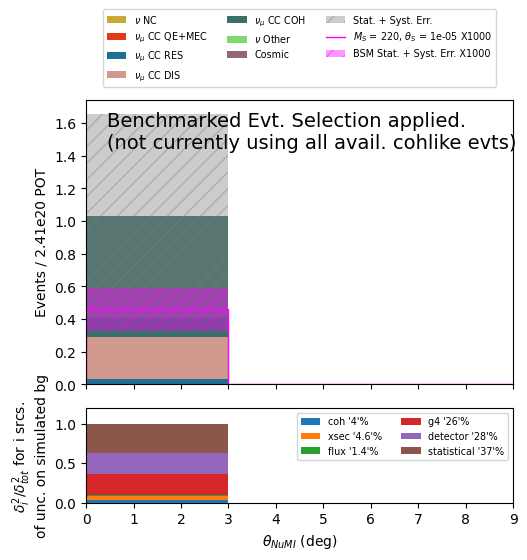

Total number of (POT-normalized) simulated background events in plot: '1.03'
Total uncertainty on simulated background events in plot: ±'0.625'
Total number of (POT-normalized) simulated signal events in plot: '0.00046'
Total uncertainty on simulated signal events in plot: ±'0.00013'


In [22]:
# Theta NuMI with Benchmarked Event Selection

bsm_detector_varis_vars = []
for bsm_sample in bsm_detector_varis_dfs:
    this_samples_vars = []
    for detect_variation_df in bsm_sample:
        this_samples_vars.append(detect_variation_df.Snumi_angle_wgtByLen*180./math.pi)
    bsm_detector_varis_vars.append(this_samples_vars)
        
x = makeplot(evtdf, evtdf.Snumi_angle_wgtByLen*180./math.pi,
         mccoh_syst_evtdfs, [sdf.Snumi_angle_wgtByLen*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,9.), bins=3,
         xlabel = "$\\theta_{NuMI}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI',
         textOnPlot = 'Benchmarked Evt. Selection applied. \n(not currently using all avail. cohlike evts)',
         bsm_index=0,
         bsm_detector_varis_vars=bsm_detector_varis_vars,
         bsm_magnifier = 1000,
         evtSel_key='I'
        )

/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_pe

/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_pe

/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_671138/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_pe

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2


/tmp/ipykernel_671138/3690885382.py:199: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


Combined result minus separate result: 
 [            nan  6.24967734e-06 -7.33915330e-04 -2.82402115e-03
  6.50562600e-05  3.58516356e-02  2.30864988e-03  3.02486701e-04
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan]


/tmp/ipykernel_671138/3690885382.py:330: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weights = df[bsm_cat].scale*df[bsm_cat].wgt.cv,
/tmp/ipykernel_671138/3690885382.py:336: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_stat_err = float(df[bsm_cat].iloc[[0]].scale)*np.sqrt(mc_bin_nevents)


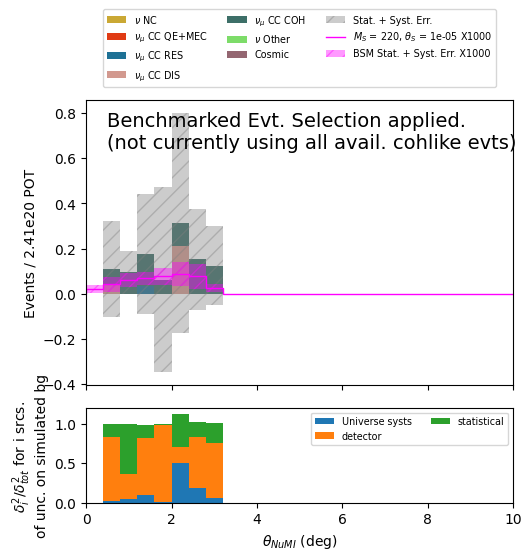

Total number of (POT-normalized) simulated background events in plot: '1.03'
Total uncertainty on simulated background events in plot: ±'0.781'
Total number of (POT-normalized) simulated signal events in plot: '0.00046'
Total uncertainty on simulated signal events in plot: ±'0.000104'


In [17]:
# Theta NuMI with Benchmarked Event Selection

bsm_detector_varis_vars = []
for bsm_sample in bsm_detector_varis_dfs:
    this_samples_vars = []
    for detect_variation_df in bsm_sample:
        this_samples_vars.append(detect_variation_df.Snumi_angle_wgtByLen*180./math.pi)
    bsm_detector_varis_vars.append(this_samples_vars)
        
x = makeplot(evtdf, evtdf.Snumi_angle_wgtByLen*180./math.pi,
         mccoh_syst_evtdfs, [sdf.Snumi_angle_wgtByLen*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,9.), bins=3,
         xlabel = "$\\theta_{NuMI}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI',
         textOnPlot = 'Benchmarked Evt. Selection applied. \n(not currently using all avail. cohlike evts)',
         bsm_index=0,
         bsm_detector_varis_vars=bsm_detector_varis_vars,
         bsm_magnifier = 1000,
         evtSel_key='I'
        )

In [34]:
print(x)
print(type(x))

1.8969349248700376
<class 'numpy.float64'>


/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2


/tmp/ipykernel_4091925/3186042509.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weights = df[bsm_cat].scale*df[bsm_cat].wgt.cv,
/tmp/ipykernel_4091925/3186042509.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_stat_err = float(df[bsm_cat].iloc[[0]].scale)*np.sqrt(mc_bin_nevents)


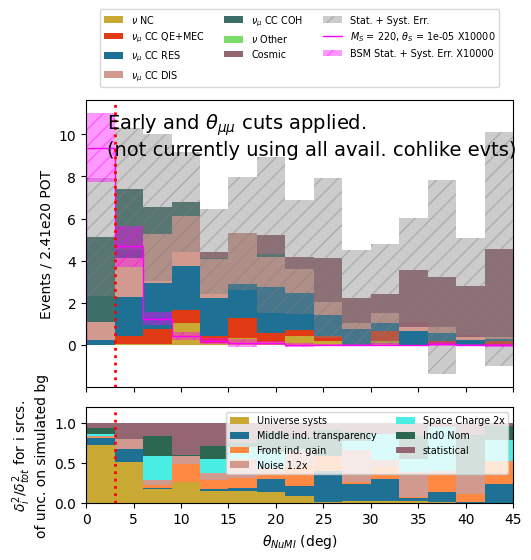

Total number of (POT-normalized) simulated background events in plot: '67.9'
Total uncertainty on simulated background events in plot: ±'46'
Total number of (POT-normalized) simulated signal events in plot: '0.00163'
Total uncertainty on simulated signal events in plot: ±'0.000395'


In [45]:
# Explore Sideband Defined as Flipped theta_NuMI

bsm_detector_varis_vars = []
for bsm_sample in bsm_detector_varis_dfs:
    this_samples_vars = []
    for detect_variation_df in bsm_sample:
        this_samples_vars.append(detect_variation_df.Snumi_angle_wgtByLen*180./math.pi)
    bsm_detector_varis_vars.append(this_samples_vars)
        
makeplot(evtdf, evtdf.Snumi_angle_wgtByLen*180./math.pi,
         mccoh_syst_evtdfs, [sdf.Snumi_angle_wgtByLen*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,45.), bins=15, vline=[3.], xlabel = "$\\theta_{NuMI}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI',
         textOnPlot = 'Early and $\\theta_{\mu\mu}$ cuts applied. \n(not currently using all avail. cohlike evts)',
         bsm_index=0,
         bsm_detector_varis_vars=bsm_detector_varis_vars,
         bsm_magnifier = 10000,
         evtSel_key='J'
        )

In [42]:
for c in evtdf.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', '', '', '')
('slc', 'truth', 'parent_dc

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2


/tmp/ipykernel_4091925/3186042509.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weights = df[bsm_cat].scale*df[bsm_cat].wgt.cv,
/tmp/ipykernel_4091925/3186042509.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_stat_err = float(df[bsm_cat].iloc[[0]].scale)*np.sqrt(mc_bin_nevents)


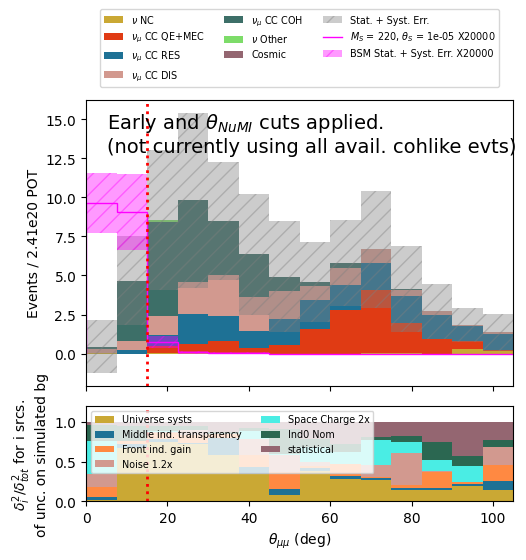

Total number of (POT-normalized) simulated background events in plot: '70.3'
Total uncertainty on simulated background events in plot: ±'41.7'
Total number of (POT-normalized) simulated signal events in plot: '0.00098'
Total uncertainty on simulated signal events in plot: ±'0.00025'


In [44]:
# Explore Sideband Defined as Flipped theta_mumu

bsm_detector_varis_vars = []
for bsm_sample in bsm_detector_varis_dfs:
    this_samples_vars = []
    for detect_variation_df in bsm_sample:
        this_samples_vars.append(detect_variation_df.opening_angle*180./math.pi)
    bsm_detector_varis_vars.append(this_samples_vars)
        
makeplot(evtdf, evtdf.opening_angle*180./math.pi,
         mccoh_syst_evtdfs, [sdf.opening_angle*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,105.), bins=14, vline=[15.], xlabel = "$\\theta_{\mu\mu}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_mumu',
         textOnPlot = 'Early and $\\theta_{NuMI}$ cuts applied. \n(not currently using all avail. cohlike evts)',
         bsm_index=0,
         bsm_detector_varis_vars=bsm_detector_varis_vars,
         bsm_magnifier = 20000,
         evtSel_key='K'
        )


/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
/tmp/ipykernel_4091925/255388292.py:52: RuntimeWarning: invalid value encountered in divide
  cut_results

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2


/tmp/ipykernel_4091925/3186042509.py:160: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)
/tmp/ipykernel_4091925/3186042509.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weights = df[bsm_cat].scale*df[bsm_cat].wgt.cv,
/tmp/ipykernel_4091925/3186042509.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mc_stat_err = float(df[bsm_cat].iloc[[0]].scale)*np.sqrt(mc_bin_nevents)


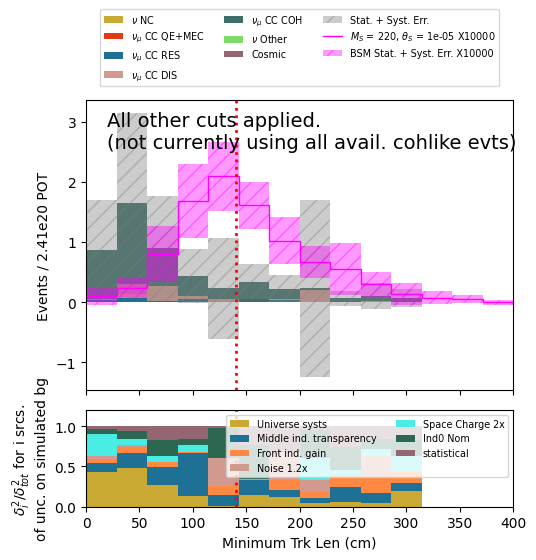

Total number of (POT-normalized) simulated background events in plot: '5.11'
Total uncertainty on simulated background events in plot: ±'6.96'
Total number of (POT-normalized) simulated signal events in plot: '0.000934'
Total uncertainty on simulated signal events in plot: ±'0.000403'


In [52]:
# Explore Sideband wrt Track Length

bsm_detector_varis_vars = []
for bsm_sample in bsm_detector_varis_dfs:
    this_samples_vars = []
    for detect_variation_df in bsm_sample:
        this_samples_vars.append(detect_variation_df.shorter_track_length)
    bsm_detector_varis_vars.append(this_samples_vars)
        
makeplot(evtdf, evtdf.shorter_track_length,
         mccoh_syst_evtdfs, [sdf.shorter_track_length for sdf in mccoh_syst_evtdfs],
         (0,400.), bins=14, vline=[140.0], xlabel = "Minimum Trk Len (cm)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='trkLen',
         textOnPlot = 'All other cuts applied. \n(not currently using all avail. cohlike evts)',
         bsm_index=0,
         bsm_detector_varis_vars=bsm_detector_varis_vars,
         bsm_magnifier = 10000,
         evtSel_key='L'
        )

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2
[0.49176854 0.8075605  0.74406262 0.84588782 0.89228598 0.69068775
 0.92026143 0.85284937 0.76131278 0.927426   0.76602507 0.78192853
 0.77062276 0.50531138 0.60504579 0.32509903 0.31621652 0.2829482
 0.17605485 0.13559829 0.17334051 0.0534051  0.03923725 0.00585867
 0.0040233 ]
running sum:
[0.49176854 0.8075605  0.74406262 0.84588782 0.89228598 0.69068775
 0.92026143 0.85284937 0.76131278 0.927426   0.76602507 0.78192853
 0.77062276 0.50531138 0.60504579 0.32509903 0.31621652 0.2829482
 0.17605485 0.13559829 0.17334051 0.0534051  0.03923725 0.00585867
 0.0040233 ]
[0.00934477 0.04964293 0.02496197 0.0448164  0.03448711 0.0116307
 0.01161154 0.03940166 0.03179028 0.01441734 0.07084711 0.03851696
 0.08997049 0.056914   0.09368903 0.05640642 0.15994491 0.18646117
 0.07195568 0.27802487 0.35141691 0.24085815 0.18425634 0.21809734
 0.31742622]
running sum:
[0.50111331 0.85720344 0.7690

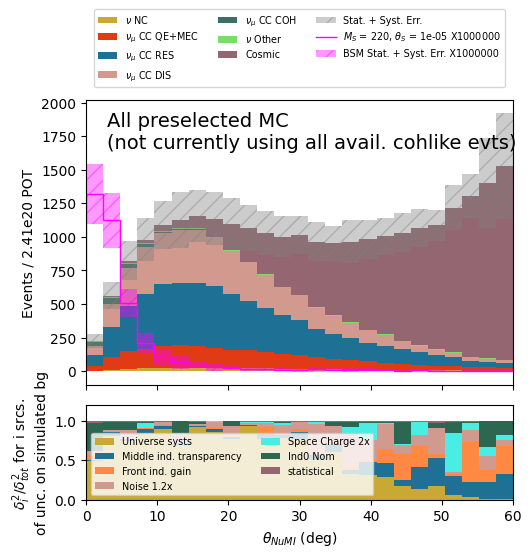

Total number of (POT-normalized) simulated background events in plot: '2.58e+04'
Total uncertainty on simulated background events in plot: ±'4.23e+03'
Total number of (POT-normalized) simulated signal events in plot: '0.00356'
Total uncertainty on simulated signal events in plot: ±'0.000935'


In [66]:
bsm_detector_varis_vars = []
for bsm_sample in bsm_detector_varis_dfs:
    this_samples_vars = []
    for detect_variation_df in bsm_sample:
        this_samples_vars.append(detect_variation_df.Snumi_angle_wgtByLen*180./math.pi)
    bsm_detector_varis_vars.append(this_samples_vars)
        
makeplot(evtdf, evtdf.Snumi_angle_wgtByLen*180./math.pi,
         mccoh_syst_evtdfs, [sdf.Snumi_angle_wgtByLen*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,60.), xlabel = "$\\theta_{NuMI}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI',
         textOnPlot = 'All preselected MC \n(not currently using all avail. cohlike evts)',
         bsm_index=0,
         bsm_detector_varis_vars=bsm_detector_varis_vars,
         bsm_magnifier = 1000000
        )

VERIFY THAT THIS NUMBER IS TWO (1 cohlike sample + 1 nominal sample, for two different POT scalings):  2


UnboundLocalError: local variable 'middle_ind_cov' referenced before assignment

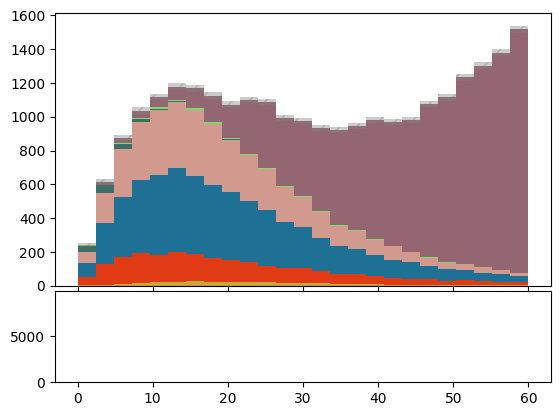

In [22]:
makeplot(evtdf, evtdf.Snumi_angle_mcs*180./math.pi,
         mccoh_syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,60.), xlabel = "MCS $\\theta_{NuMI}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI', 
         textOnPlot = 'All preselected MC \n(not currently using all avail. cohlike evts)',
        do_systs=False)

In [ ]:
# TODO: bottom panel: show uncert. squared (then I can show breakdown of contributing types.)
# To get model systematics: 

# what's my goal? Make a plot that shows:
# DONE - neutrinos, stacked by type, with total uncertainty
# - bsm benchmark(s) that are given (single or a list), plotted as line hist, with total uncertainty
# - (to be added later: ) data as data points, with statistical error
# - bottom panel shows breakdown of fractional uncertainty for each type of uncertainty, in each bin, as stacked hist.

# plot inputs:
# - nu_evtdf (concatenated from nominal nu df and cohlike dfs)
# - cohlike_evtdfs
# - bsm_df (one df per benchmark mass you want to plot)
# - list of sets (list of lists) of bsm detector variations 

In [44]:
print(len(soladero))

7


In [ ]:
# ma_300_syst_evtdfs, ma_300_syst_hdrs = extract_detVar_dfs("ma_300")

In [25]:
for df in ma_300_syst_evtdfs: 
    print(df.shape)
df = ma_300_syst_evtdfs[0]
for c in df.columns: print(c)
#plt.hist(df.Snumi_angle_wgtByLen*180/math.pi, 20)
#plt.show()

(165, 798)
(149, 798)
(172, 798)
(150, 798)
(165, 798)
(161, 798)
(145, 798)
('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'time', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')

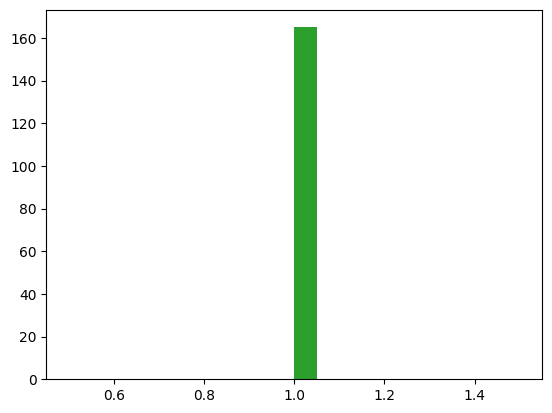

In [27]:
plt.hist(df.wgt.cv, 20)
plt.hist(df.wgt.concrete.cv, 20)
plt.hist(df.wgt.coh.cv, 20)
plt.show()